Previsão da variável "meantemp" do dataset daily-climate-time-series-data, esse notebook foi usado para testa vários neurônios (LSTM, GRU, neurônio vanilla da RNN), tamnhos do lag e features do dataset a serem usadas.

A arquitetura final foi usando o GRU com duas camadas oculas 32 -> 16 e usando `meantemp` e `meanpressure` com features de entrada.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sumanthvrao/daily-climate-time-series-data")

print("Path to dataset files:", path)

df = pd.read_csv(path + "/DailyDelhiClimateTrain.csv")
df_test = pd.read_csv(path + "/DailyDelhiClimateTest.csv")

Using Colab cache for faster access to the 'daily-climate-time-series-data' dataset.
Path to dataset files: /kaggle/input/daily-climate-time-series-data


In [ ]:
# Processamento da coluna de data
for dataset in [df, df_test]:
    dataset["date"] = dataset["date"].apply(lambda a: a.replace("-", ""))
    dataset["date"] = pd.to_datetime(dataset["date"], format='%Y%m%d')
    dataset.set_index("date", inplace=True)

In [ ]:
# process outliers pressure
pressure = df['meanpressure']

Q1 = pressure.quantile(0.25)
Q3 = pressure.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
outliers = df[(pressure < lower) | (pressure > upper)]

df['meanpressure'] = np.where(
    (pressure < lower) | (pressure > upper),
    np.nan,
    pressure
)
df['meanpressure'] = df['meanpressure'].interpolate(method='time')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [ ]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1008.249852
std,7.348103,16.769652,4.561602,7.437428
min,6.000000,13.428571,0.000000,991.375000
25%,18.857143,50.375000,3.475000,1001.625000
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.875000
max,38.714286,100.000000,42.220000,1023.000000


In [ ]:
df_test.describe()

,meantemp,humidity,wind_speed,meanpressure
count,114.000000,114.000000,114.000000,114.000000
mean,21.713079,56.258362,8.143924,1004.035090
std,6.360072,19.068083,3.588049,89.474692
min,11.000000,17.750000,1.387500,59.000000
25%,16.437198,39.625000,5.563542,1007.437500
50%,19.875000,57.750000,8.069444,1012.739316
75%,27.705357,71.902778,10.068750,1016.739583
max,34.500000,95.833333,19.314286,1022.809524


# Preparação dos dados

In [ ]:
# Cria sequências onde X contém as features e y contém o valor do target no próximo timestep
def create_sequences_multivariate(data_features, data_target, seq_length):
    X, y = [], []
    for i in range(len(data_features) - seq_length):
        X.append(data_features[i:i+seq_length, :])
        y.append(data_target[i+seq_length])

    return np.array(X), np.array(y)


In [ ]:
# Parâmetros
INPUT_FEATURES = ['meantemp', 'meanpressure']
TARGET = 'meantemp'
seq_length = 30

# Extrair features de entrada
data_features = df[INPUT_FEATURES].values
data_target = df[TARGET].values

# Normalização
features_mean = data_features.mean(axis=0)
features_std = data_features.std(axis=0)
data_features_normalized = (data_features - features_mean) / features_std

target_mean = data_target.mean()
target_std = data_target.std()
data_target_normalized = (data_target - target_mean) / target_std

num_features = len(INPUT_FEATURES)

# Criar sequências para treino/validação
X_train_val, y_train_val = create_sequences_multivariate(
    data_features_normalized,
    data_target_normalized,
    seq_length=seq_length
)

X_train_val = torch.FloatTensor(X_train_val)
y_train_val = torch.FloatTensor(y_train_val).unsqueeze(-1)

# Split treino/validação
total_len = len(X_train_val)
train_size = int(0.7 * total_len)

X_train = X_train_val[:train_size]
y_train = y_train_val[:train_size]
X_val = X_train_val[train_size:]
y_val = y_train_val[train_size:]

# Preparar dados de teste
data_test_features = df_test[INPUT_FEATURES].values
data_test_target = df_test[TARGET].values

data_test_features_normalized = (data_test_features - features_mean) / features_std
data_test_target_normalized = (data_test_target - target_mean) / target_std

X_test, y_test = create_sequences_multivariate(
    data_test_features_normalized,
    data_test_target_normalized,
    seq_length=seq_length
)

X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).unsqueeze(-1)

# RNN

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_sizes=[64, 32, 16], output_size=1, cell_type='Vanilla'):
        """
        Args:
            input_size: número de features de entrada
            hidden_sizes: LISTA com número de neurônios em cada camada
            output_size: número de valores a prever
            cell_type: 'RNN', 'LSTM' ou 'GRU'
        """
        super(RNN, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.num_layers = len(hidden_sizes)
        self.cell_type = cell_type

        self.rnn_layers = nn.ModuleList()

        for i in range(self.num_layers):
            input_dim = input_size if i == 0 else hidden_sizes[i-1]
            output_dim = hidden_sizes[i]

            # tipo de celula
            if cell_type == 'LSTM':
                self.rnn_layers.append(
                    nn.LSTM(input_dim, output_dim, num_layers=1, batch_first=True)
                )
            elif cell_type == 'GRU':
                self.rnn_layers.append(
                    nn.GRU(input_dim, output_dim, num_layers=1, batch_first=True)
                )
            else:  # RNN vanilla
                self.rnn_layers.append(
                    nn.RNN(input_dim, output_dim, num_layers=1, batch_first=True)
                )

        # Camada linear final
        self.fc = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for i, rnn_layer in enumerate(self.rnn_layers):
            # inicializa estado oculto
            h0 = torch.zeros(1, x.size(0), self.hidden_sizes[i]).to(x.device)

            if self.cell_type == 'LSTM':
                # LSTM precisa de cell state
                c0 = torch.zeros(1, x.size(0), self.hidden_sizes[i]).to(x.device)
                x, _ = rnn_layer(x, (h0, c0))
            else:
                x, _ = rnn_layer(x, h0)

        # Pega apenas o último timestep
        x = x[:, -1, :]

        out = self.fc(x)
        return out

In [ ]:
model = RNN(
    input_size=num_features,
    hidden_sizes=[16, 8],
    output_size=1,
    cell_type='GRU'
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 400
train_losses = []
val_losses = []

# Early Stopping parameters
patience = 30
min_delta = 0.001
best_val_loss = float('inf')

patience_counter = 0

for epoch in range(num_epochs):
    model.train()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Validation step
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    # Early stop
    if val_loss.item() < best_val_loss - min_delta:
        best_val_loss = val_loss.item()
        patience_counter = 0
        # save the best model
        torch.save(model.state_dict(), 'best_model_early_stop.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs due to no improvement in validation loss.')
            break

# Load the best model if early stopped
if patience_counter >= patience:
    model.load_state_dict(torch.load('best_model_early_stop.pth'))
    print('Loaded best model for evaluation.')

Epoch [1/400], Train Loss: 1.1978, Val Loss: 1.0172
Epoch [2/400], Train Loss: 0.9535, Val Loss: 0.8036
Epoch [3/400], Train Loss: 0.7519, Val Loss: 0.6324
Epoch [4/400], Train Loss: 0.5886, Val Loss: 0.4977
Epoch [5/400], Train Loss: 0.4578, Val Loss: 0.3953
Epoch [6/400], Train Loss: 0.3560, Val Loss: 0.3184
Epoch [7/400], Train Loss: 0.2785, Val Loss: 0.2608
Epoch [8/400], Train Loss: 0.2224, Val Loss: 0.2201
Epoch [9/400], Train Loss: 0.1871, Val Loss: 0.1947
Epoch [10/400], Train Loss: 0.1710, Val Loss: 0.1793
Epoch [11/400], Train Loss: 0.1675, Val Loss: 0.1643
Epoch [12/400], Train Loss: 0.1667, Val Loss: 0.1439
Epoch [13/400], Train Loss: 0.1617, Val Loss: 0.1205
Epoch [14/400], Train Loss: 0.1519, Val Loss: 0.1014
Epoch [15/400], Train Loss: 0.1405, Val Loss: 0.0923
Epoch [16/400], Train Loss: 0.1311, Val Loss: 0.0922
Epoch [17/400], Train Loss: 0.1243, Val Loss: 0.0945
Epoch [18/400], Train Loss: 0.1174, Val Loss: 0.0940
Epoch [19/400], Train Loss: 0.1078, Val Loss: 0.0907
Ep

# Avaliação

In [ ]:
model.eval()
with torch.no_grad():
    train_pred = model(X_train)
    val_pred = model(X_val)
    test_pred = model(X_test)

    # Desnormalizar
    train_pred = train_pred.numpy() * target_std + target_mean
    val_pred = val_pred.numpy() * target_std + target_mean
    test_pred = test_pred.numpy() * target_std + target_mean

    y_train_denorm = y_train.numpy() * target_std + target_mean
    y_val_denorm = y_val.numpy() * target_std + target_mean
    y_test_denorm = y_test.numpy() * target_std + target_mean



# MSE
train_mse = np.mean((train_pred - y_train_denorm) ** 2)
val_mse = np.mean((val_pred - y_val_denorm) ** 2)
test_mse = np.mean((test_pred - y_test_denorm) ** 2)

# MAE
train_mae = np.mean(abs(train_pred - y_train_denorm))
val_mae = np.mean(abs(val_pred - y_val_denorm))
test_mae = np.mean(abs(test_pred - y_test_denorm))

# MAPE
EPS = 1e-8  # evita divisão por zero

train_mape = np.mean(
    np.abs((y_train_denorm - train_pred) / (y_train_denorm + EPS))
) * 100

val_mape = np.mean(
    np.abs((y_val_denorm - val_pred) / (y_val_denorm + EPS))
) * 100

test_mape = np.mean(
    np.abs((y_test_denorm - test_pred) / (y_test_denorm + EPS))
) * 100

print(f"MAPE Treino:     {train_mape:.2f}%")
print(f"MAPE Validação:  {val_mape:.2f}%")
print(f"MAPE Teste:      {test_mape:.2f}%\n")

print(f"MSE Treino:     {train_mse:.4f}")
print(f"MSE Validação:  {val_mse:.4f}")
print(f"MSE Teste:      {test_mse:.4f}\n")

print(f"MAE Treino:     {train_mae:.4f}")
print(f"MAE Validação:  {val_mae:.4f}")
print(f"MAE Teste:      {test_mae:.4f}")


residuos = y_test_denorm - test_pred

# Convert the residuals to a pandas DataFrame and save as CSV
pd.DataFrame(residuos, columns=['residuals']).to_csv('residuos.csv', index=False)

MAPE Treino:     5.25%
MAPE Validação:  5.00%
MAPE Teste:      5.35%

MSE Treino:     2.6134
MSE Validação:  2.3421
MSE Teste:      2.4169

MAE Treino:     1.2464
MAE Validação:  1.1692
MAE Teste:      1.2248


# Visualização

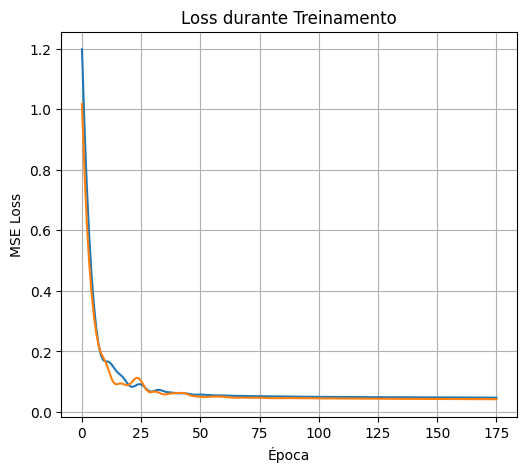

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss durante Treinamento')

plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.grid(True)

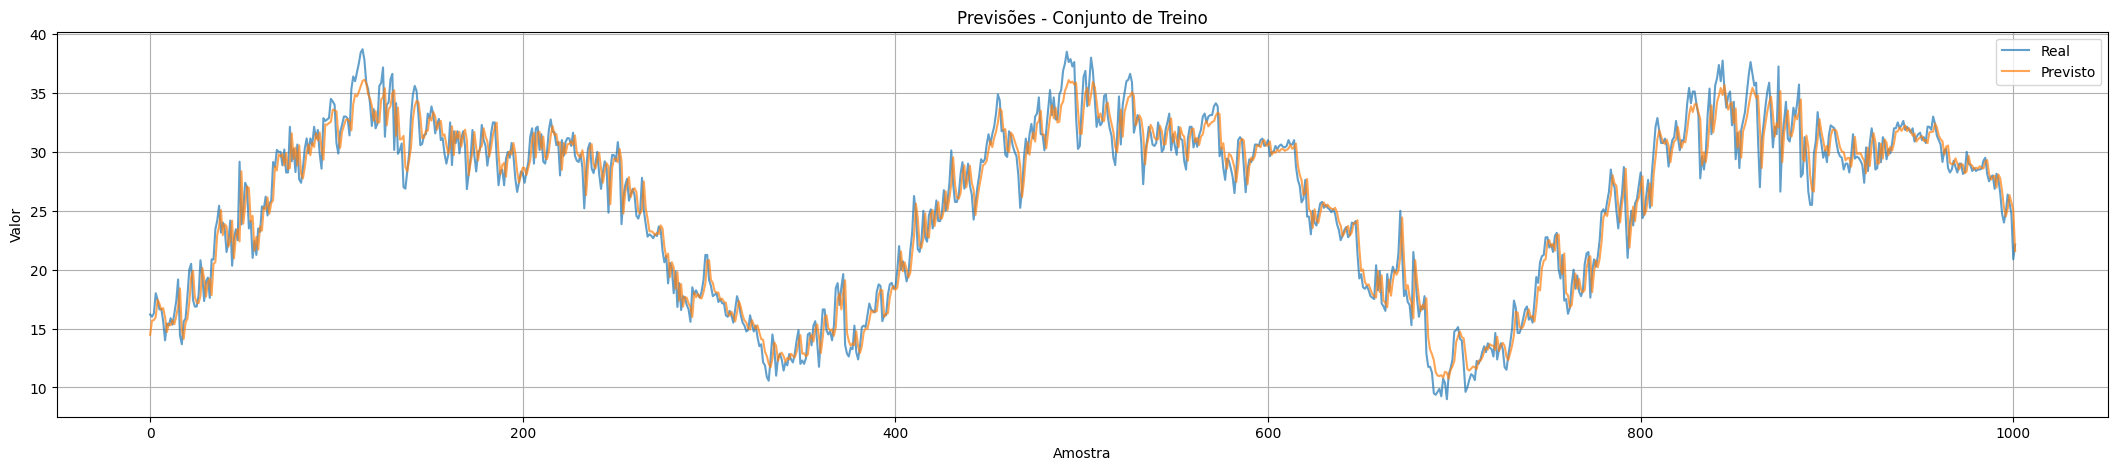

In [ ]:
plt.figure(figsize=(90, 5))
plt.subplot(1, 3, 2)
plt.plot(y_train_denorm, label='Real', alpha=0.7)
plt.plot(train_pred, label='Previsto', alpha=0.7)
plt.title('Previsões - Conjunto de Treino')
plt.xlabel('Amostra')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)


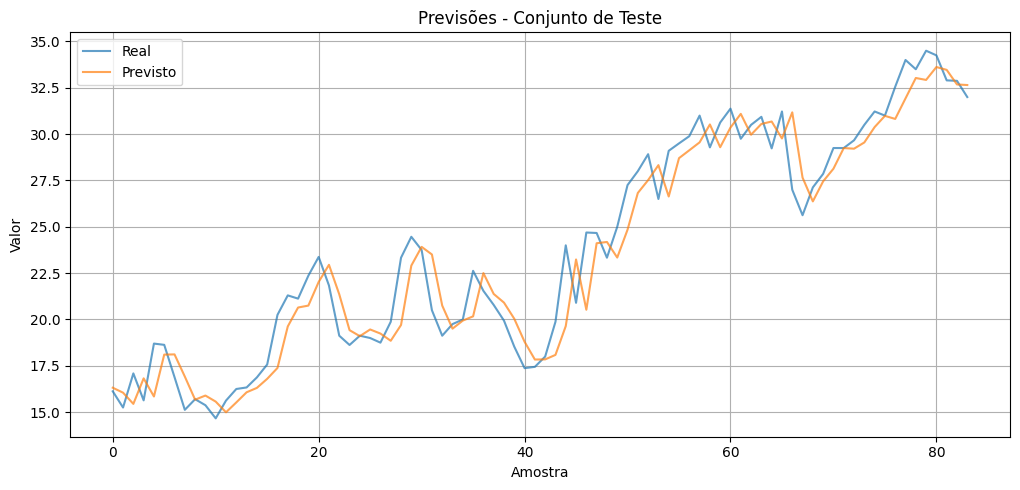

In [ ]:
plt.figure(figsize=(30, 5))
plt.subplot(1, 3, 3)
plt.plot(y_test_denorm, label='Real', alpha=0.7)
plt.plot(test_pred, label='Previsto', alpha=0.7)
plt.title('Previsões - Conjunto de Teste')
plt.xlabel('Amostra')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Depois de testar diversos parâmetros e arquiteturas, é possível verificar que:
- em ordem de impotância das features temos `wind_speed` (não é útil para o forecast) -> `humidity` (pouco util, mas não parece atrapalhar) -> `meanpressure` (ajuda no forecast) -> `meantemp` fornece uma boa previsão usando apenas ela.
- o tipo de neurônio não muda influencia tanto, existe um certo trade off entre velocidade de treinamento e quntidade de epocas, mas no fim todos chegam em um desempenho próximo. Dito isso, GRU ser o mais equilibrado entre eles.
- a quantidade de layers e neuronios parece seguir o menos principio do tiopico acima 32 -> 32 parece bom, porem menos neuronios tem um resultado parecido.
- sequências de lag muito longas (+70) são ruins



# Baseline

Se observar o gráfico de previsão do conjunto de teste é possível ver que que as previsões parecem ser apenas o dado de temperatura do dia anterior. Nessa parte do notebook, foi verificado se era isso, ou algo próximo disso, que estaja acontecendo, e sim, o MSE fazendo a temperatura $t-1$ é tão eficiente quanto a RNN. Talvez faça sentido para prever dados bem mais a frente do que 1 dia, mas para a temperatura de amanhã basta ohar a de hoje.

In [ ]:
data = df["meantemp"].values

data_mean = data.mean(axis=0)
data_std = data.std(axis=0)
data_train_val_normalized = (data - data_mean) / data_std

def baseline_prediction(X):
    return X[:, -1, 0].numpy()

# Previsões baseline (dados normalizados)
baseline_train = baseline_prediction(X_train)
baseline_val = baseline_prediction(X_val)
baseline_test = baseline_prediction(X_test)

# Desnormalizar baseline
baseline_train_denorm = baseline_train * data_std + data_mean
baseline_val_denorm = baseline_val * data_std + data_mean
baseline_test_denorm = baseline_test * data_std + data_mean

# Valores reais desnormalizados
y_train_denorm = y_train.numpy().flatten() * data_std + data_mean
y_val_denorm = y_val.numpy().flatten() * data_std + data_mean
y_test_denorm = y_test.numpy().flatten() * data_std + data_mean

# MSE
baseline_train_mse = np.mean((baseline_train_denorm - y_train_denorm) ** 2)
baseline_val_mse = np.mean((baseline_val_denorm - y_val_denorm) ** 2)
baseline_test_mse = np.mean((baseline_test_denorm - y_test_denorm) ** 2)

print("MSE do Baseline")
print(f"MSE Treino    :  {baseline_train_mse:.4f}")
print(f"MSE Validação :  {baseline_val_mse:.4f}")
print(f"MSE Teste     :  {baseline_test_mse:.4f}")

MSE do Baseline
MSE Treino    :  2.8537
MSE Validação :  2.4965
MSE Teste     :  2.4586


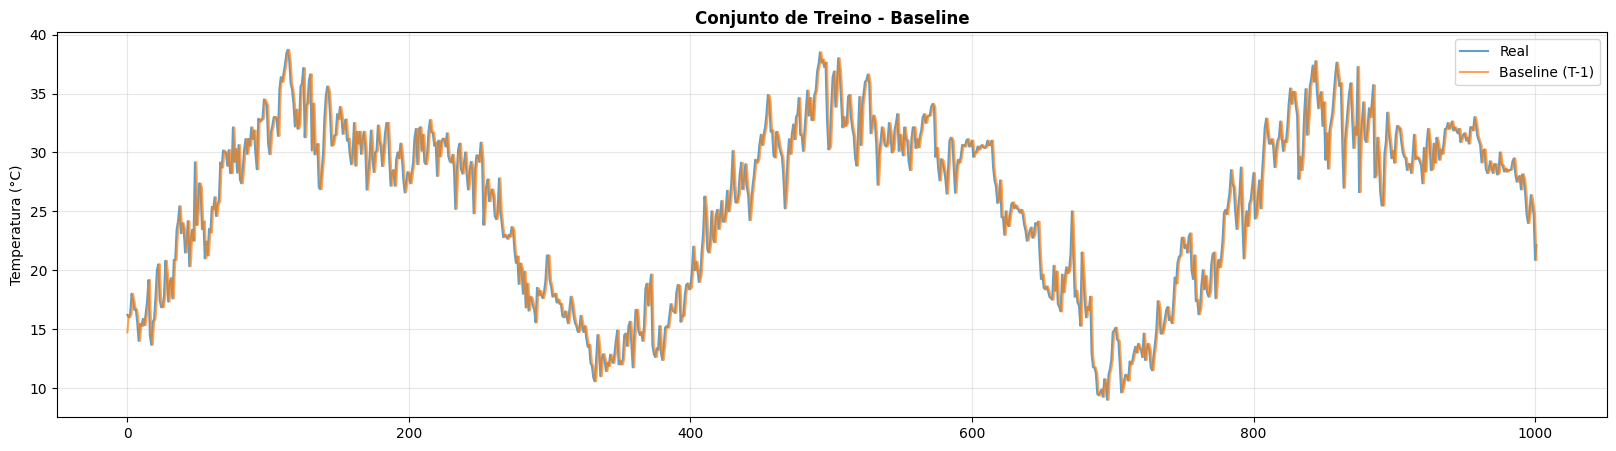

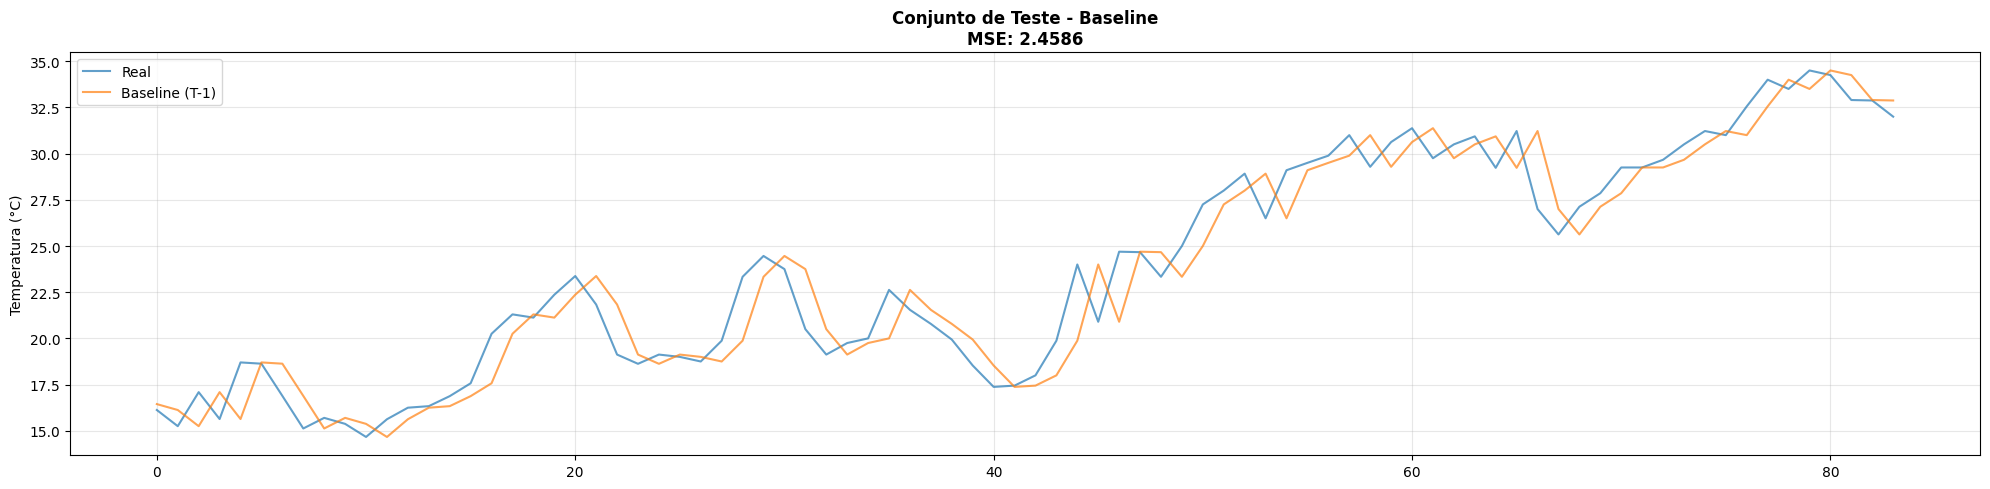

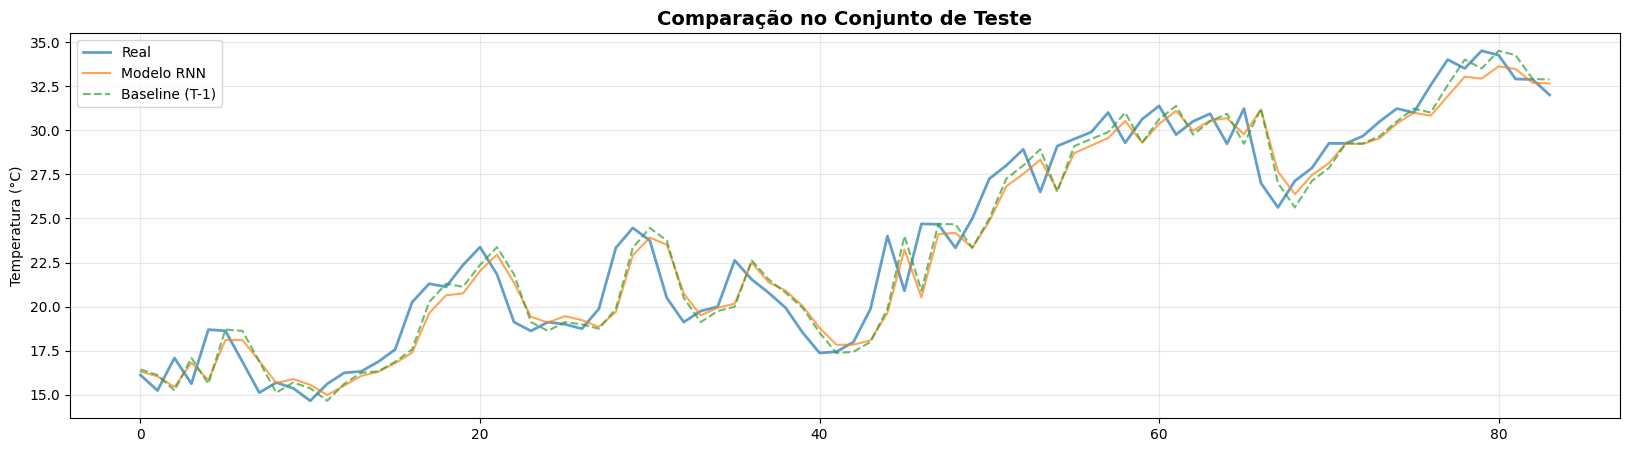

In [ ]:
# Previsões no conjunto de treino (Baseline)
plt.figure(figsize=(20, 5))
plt.plot(y_train_denorm, label='Real', alpha=0.7, linewidth=1.5)
plt.plot(baseline_train_denorm, label='Baseline (T-1)', alpha=0.7, linewidth=1.5)
plt.title('Conjunto de Treino - Baseline', fontsize=12, fontweight='bold')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True, alpha=0.3)

# Previsões no conjunto de teste (Baseline)
plt.figure(figsize=(20, 5))


plt.plot(y_test_denorm, label='Real', alpha=0.7, linewidth=1.5)
plt.plot(baseline_test_denorm, label='Baseline (T-1)', alpha=0.7, linewidth=1.5)
plt.title(f'Conjunto de Teste - Baseline\nMSE: {baseline_test_mse:.4f}',
          fontsize=12, fontweight='bold')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Gráfico de comparação direta (apenas teste)
plt.figure(figsize=(20, 5))

plt.plot(y_test_denorm, label='Real', alpha=0.7, linewidth=2)
plt.plot(test_pred, label='Modelo RNN', alpha=0.7, linewidth=1.5)
plt.plot(baseline_test_denorm, label='Baseline (T-1)', alpha=0.7, linewidth=1.5, linestyle='--')
plt.title('Comparação no Conjunto de Teste', fontsize=14, fontweight='bold')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True, alpha=0.3)

# Salvar modelo

In [ ]:
PATH = "menormse->gru-16-16-pressure-temp-humidity-len80.pth"
# torch.save(model.state_dict(), PATH)